# 패키지

In [1]:
# 필요한 패키지
import os                           # 운영체제
import time                         # 시간
import tensorflow as tf             # 텐서플로
import tensorflow_addons as tfa     # 텐서플로 에드온
import pandas as pd                 # 판다스
import matplotlib.pyplot as plt     # 그래프 도구
import MSRL                         # Musical Symbol Recognition Library

c:\Users\chorokmoo_win\.conda\envs\new2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\chorokmoo_win\.conda\envs\new2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

# 손실

In [2]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()
train, valid, test = msDataset.ds_OD()

# 모델
msModel = MSRL.models.MusicalSymbolModel()
model = msModel.model_OD2()

-- TFDS Train ------------------
input  : (20000,), <dtype: 'string'>
output : (20000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 20000
number of each class : [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]

-- TFDS Validation ------------------
input  : (400,), <dtype: 'string'>
output : (400, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 400
number of each class : [400, 400, 243, 187, 218, 150, 204, 240, 217, 234]

-- TFDS Test ------------------
input  : (400,), <dtype: 'string'>
output : (400, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 400
number of each class : [400, 400, 238, 201, 222, 156, 200, 255, 222, 238]



In [3]:
# 손실
model_loss = MSRL.losses.WeightedMultiTaskLoss(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722])

In [4]:
for input in train.take(1):
    true = input[1]
    pred = model(input[0])

model_loss.call(true, pred)

tf.Tensor([0.4686538], shape=(1,), dtype=float32)
tf.Tensor([0.00108568], shape=(1,), dtype=float32)
tf.Tensor([0.6932814], shape=(1,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=14.145842>

In [5]:
true_0_0 = tf.reshape(true, shape=(32, -1, 7))[0][0]
true_0_0

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.       , 0.5234375, 0.9947917, 0.8828125, 0.5      , 0.5      ,
       1.       ], dtype=float32)>

In [6]:
pred_0_0 = tf.reshape(pred, shape=(32, -1, 7))[0][0]
pred_0_0

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.49952802, 0.5014145 , 0.5013559 , 0.5015723 , 0.49860474,
       0.50077486, 0.4999329 ], dtype=float32)>

# 평가지표

In [2]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()
train, valid, test = msDataset.ds_OD()

# 모델
msModel = MSRL.models.MusicalSymbolModel()
model = msModel.model_OD3()

-- TFDS Train ------------------
input  : (20000,), <dtype: 'string'>
output : (20000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 20000
number of each class : [20000, 20000, 12384, 9915, 11272, 7575, 9942, 12213, 10637, 11760]

-- TFDS Validation ------------------
input  : (2000,), <dtype: 'string'>
output : (2000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 2000
number of each class : [2000, 2000, 1253, 984, 1123, 753, 997, 1240, 1058, 1195]

-- TFDS Test ------------------
input  : (2000,), <dtype: 'string'>
output : (2000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 2000
number of each class : [2000, 2000, 1223, 979, 1108, 774, 977, 1229, 1068, 1138]



In [3]:
# 모델 평가지표
model_metric = MSRL.metrics.IoU(512, 192)

In [4]:
for input in train.take(1):
    true = input[1]
    pred = model(input[0])

model_metric.update_state(true, pred)
model_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.1322671>

# 데이터셋

In [2]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()
train, valid, test = msDataset.ds_OD()

# 모델
msModel = MSRL.models.MusicalSymbolModel()
model = msModel.model_OD()

-- TFDS Train ------------------
input  : (20000,), <dtype: 'string'>
output : (20000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 20000
number of each class : [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]

-- TFDS Validation ------------------
input  : (400,), <dtype: 'string'>
output : (400, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 400
number of each class : [400, 400, 243, 187, 218, 150, 204, 240, 217, 234]

-- TFDS Test ------------------
input  : (400,), <dtype: 'string'>
output : (400, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 400
number of each class : [400, 400, 238, 201, 222, 156, 200, 255, 222, 238]



In [3]:
import numpy as np
import cv2

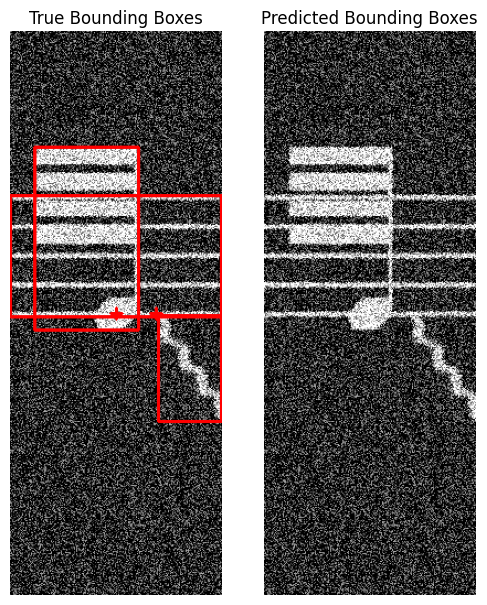

In [8]:
for input in train.take(1):
    image = input[0]
    true = input[1]
    pred = model(input[0])

# shape 변경
true = tf.reshape(true, shape=(32, -1, 7))
pred = tf.reshape(pred, shape=(32, -1, 7))

# 원래 스케일로 복원 (0~255)
image = tf.squeeze(image, axis=-1)  # (32, 512, 192)
image = image * 255  # 0~1 범위를 0~255 범위로 변환
image = tf.clip_by_value(image, 0, 255)  # 0과 255로 클리핑
image = tf.cast(image, tf.uint8)  # uint8로 변환

# 이미지 크기 조사
image_height = tf.shape(image[0])[0].numpy()
image_width = tf.shape(image[0])[1].numpy()

# 컬러로 바꿔야 하므로 grayscale 이미지를 채널을 3개로 복제
image = tf.repeat(image[..., tf.newaxis], repeats=3, axis=-1)  # (32, 512, 192, 3)

# 바운딩 박스를 그릴 색상을 준비
colors = [(255, 0, 0), (0, 0, 255), (0, 255, 0), (255, 255, 0), (255, 0, 255)]  # 다양한 색상 리스트

# 배치에서 첫 번째 이미지만을 시각화 예시로 사용
image_np = image[0].numpy().astype(np.uint8)  # 첫 번째 이미지를 numpy로 변환
true_boxes = true[0].numpy()  # 첫 번째 이미지의 실제 바운딩 박스
pred_boxes = pred[0].numpy()  # 첫 번째 이미지의 예측 바운딩 박스

# 바운딩 박스를 그리는 함수
def draw_bounding_boxes(image, boxes, color):
    for box in boxes:
        x1 = box[0] * image_width
        y1 = box[1] * image_height
        x2 = box[2] * image_width
        y2 = box[3] * image_height
        cx = box[4] * image_width
        cy = box[5] * image_height
        if x1 > x2 or y1 > y2:
            continue
        start_point = (int(x1), int(y1))
        end_point = (int(x2), int(y2))
        center_point = (int(cx), int(cy))
        cv2.rectangle(image, start_point, end_point, color, 2)
        cv2.drawMarker(image, center_point, color, markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2)
    return image

# 실제 바운딩 박스 그리기 (파란색)
image_with_true_boxes = draw_bounding_boxes(image_np.copy(), true_boxes, colors[0])

# 예측 바운딩 박스 그리기 (빨간색)
image_with_pred_boxes = draw_bounding_boxes(image_np.copy(), pred_boxes, colors[1])

# 이미지를 시각화
plt.figure(figsize=(6, 9))

# 실제 바운딩 박스가 그려진 이미지
plt.subplot(1, 2, 1)
plt.imshow(image_with_true_boxes)
plt.title('True Bounding Boxes')
plt.axis('off')

# 예측 바운딩 박스가 그려진 이미지
plt.subplot(1, 2, 2)
plt.imshow(image_with_pred_boxes)
plt.title('Predicted Bounding Boxes')
plt.axis('off')

# 이미지 간격 조정
plt.subplots_adjust(wspace=0.2)  # 이미지 사이의 간격 조정

plt.show()

# 손실 클래스 작성

In [7]:
y_true = tf.constant([[10, 10, 50, 50, 30, 30, 20, 20, 60, 60, 40, 40, 0, 0, 0, 0, 0, 0],
                      [10, 10, 50, 50, 30, 30, 20, 20, 60, 60, 40, 40, 0, 0, 0, 0, 0, 0],
                      [10, 10, 50, 50, 30, 30, 20, 20, 60, 60, 40, 40, 0, 0, 0, 0, 0, 0]], dtype=tf.int16)
y_pred = tf.constant([[47, 15, 15, 48, 31, 31, 20, 20, 60, 60, 40, 40, 0, 7, 8, 0, 0, 0],
                      [47, 15, 15, 48, 31, 31, 20, 20, 60, 60, 40, 40, 0, 7, 8, 0, 0, 0],
                      [10, 10, 50, 50, 30, 30, 20, 20, 60, 60, 40, 40, 0, 0, 0, 0, 0, 0]], dtype=tf.float32)

In [8]:
y_true = tf.cast(y_true, dtype=y_pred.dtype)

In [18]:
y_pred = tf.cast(y_pred, dtype=y_true.dtype)

In [9]:
y_true = tf.reshape(y_true, shape=(-1, 3, 6))
y_pred = tf.reshape(y_pred, shape=(-1, 3, 6))

In [10]:
y_true

<tf.Tensor: shape=(3, 3, 6), dtype=float32, numpy=
array([[[10., 10., 50., 50., 30., 30.],
        [20., 20., 60., 60., 40., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]],

       [[10., 10., 50., 50., 30., 30.],
        [20., 20., 60., 60., 40., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]],

       [[10., 10., 50., 50., 30., 30.],
        [20., 20., 60., 60., 40., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]], dtype=float32)>

In [24]:
# 0. 좌표 정렬
def sort_coordinate(box):
    # 각각의 좌표로 나누기
    x1 = box[:, :, 0:1]
    y1 = box[:, :, 1:2]
    x2 = box[:, :, 2:3]
    y2 = box[:, :, 3:4]

    # 좌표 크기 비교
    new_x1 = tf.minimum(x1, x2)
    new_y1 = tf.minimum(y1, y2)
    new_x2 = tf.maximum(x1, x2)
    new_y2 = tf.maximum(y1, y2)

    # 텐서 하나로 만들기
    return tf.concat([new_x1, new_y1, new_x2, new_y2], axis=-1)

# 1-1. 박스 넓이 계산
def box_area(box):
    # 각각의 좌표로 나누기
    x1 = box[:, :, 0:1]
    y1 = box[:, :, 1:2]
    x2 = box[:, :, 2:3]
    y2 = box[:, :, 3:4]

    # 넓이 계산
    return tf.abs((x2-x1) * (y2-y1))

# 1-2. 교집합이 있는지 확인
def is_intersection(box1, box2):
    # 각각의 좌표로 나누기
    b1_x1 = box1[:, :, 0:1]
    b1_y1 = box1[:, :, 1:2]
    b1_x2 = box1[:, :, 2:3]
    b1_y2 = box1[:, :, 3:4]
    b2_x1 = box2[:, :, 0:1]
    b2_y1 = box2[:, :, 1:2]
    b2_x2 = box2[:, :, 2:3]
    b2_y2 = box2[:, :, 3:4]

    # 첫 번째 박스가 두 번째 박스와 겹치는지 확인
    condition1 = tf.logical_and(b1_x1 < b2_x2, b1_y1 < b2_y2)
    condition2 = tf.logical_and(b1_x2 > b2_x1, b1_y2 > b2_y1)
    
    # 두 번째 박스가 첫 번째 박스와 겹치는지 확인
    condition3 = tf.logical_and(b2_x1 < b1_x2, b2_y1 < b1_y2)
    condition4 = tf.logical_and(b2_x2 > b1_x1, b2_y2 > b1_y1)

    # 어느 한 조건이라도 만족하면 교집합이 있는 것
    has_inter = tf.logical_or(tf.logical_and(condition1, condition2), tf.logical_and(condition3, condition4))

    return has_inter

# 1-3. IoU 계산
def compute_IoU(box1, box2):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(box1, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(box2, "NaN or Inf is not allowed")

    # 예측 박스 좌표 정렬
    box2 = sort_coordinate(box2)

    # box 넓이 계산
    box1_area = box_area(box1) # 절대 0이 될 수 없음. 앞에서 필터링됨. 근데 왜 있을까..?
    box2_area = box_area(box2)
    

    # 교집합 영역이 있는지 검사
    intersection = is_intersection(box1, box2)

    # 교집합 영역의 박스 좌표 구함
    box3 = tf.concat([
        tf.maximum(box1[:, :, 0:1], box2[:, :, 0:1]),
        tf.maximum(box1[:, :, 1:2], box2[:, :, 1:2]),
        tf.minimum(box1[:, :, 2:3], box2[:, :, 2:3]),
        tf.minimum(box1[:, :, 3:4], box2[:, :, 3:4])
    ], axis=-1)
    
    # 교집합 영역의 넓이 계산
    intersection_area = tf.where(intersection, box_area(box3), 0.0)
    tf.debugging.check_numerics(intersection_area, "NaN or Inf is not allowed")

    # 합집합 영역 계산
    union_area = box1_area + box2_area - intersection_area
    tf.debugging.check_numerics(union_area, "NaN or Inf is not allowed")

    # iou 계산
    iou = intersection_area / union_area
    tf.debugging.check_numerics(iou, "NaN or Inf is not allowed")

    # 0~1 사이값 리턴
    return 1.0 - iou

# 2-1. 중심점 계산
def get_center(box):
    # 각각의 좌표로 나누기
    x1 = box[:, :, 0:1]
    y1 = box[:, :, 1:2]
    x2 = box[:, :, 2:3]
    y2 = box[:, :, 3:4]

    # 중심점 계산
    cx = (x1 + x2) / 2.0
    cy = (y1 + y2) / 2.0
    return cx, cy

# 2-2. 박스 대각선 길이 계산
def box_diagonal(box):
    # 각각의 좌표로 나누기
    x1 = box[:, :, 0:1]
    y1 = box[:, :, 1:2]
    x2 = box[:, :, 2:3]
    y2 = box[:, :, 3:4]

    # 대각선 길이 계산
    return tf.sqrt((x2 - x1) ** 2 + (y2 -y1) ** 2)

# 2-3. 두 박스의 중심점 거리 계산 -> 0 이상의 값 리턴
def center_distance(box1, box2):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(box1, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(box2, "NaN or Inf is not allowed")

    # 예측 박스 좌표 정렬
    box2 = sort_coordinate(box2)

    # 두 박스의 중심점 사이 거리
    b1_cx, b1_cy = get_center(box1)
    b2_cx, b2_cy = get_center(box2)
    box_distance = tf.sqrt((b2_cx - b1_cx) ** 2 + (b2_cy - b1_cy) ** 2)
    tf.debugging.check_numerics(box_distance, "NaN or Inf is not allowed")

    # 두 박스를 모두 포함하는 합집합 영역의 대각선 길이
    box4 = tf.concat([
        tf.minimum(box1[:, :, 0:1], box2[:, :, 0:1]),
        tf.minimum(box1[:, :, 1:2], box2[:, :, 1:2]),
        tf.maximum(box1[:, :, 2:3], box2[:, :, 2:3]),
        tf.maximum(box1[:, :, 3:4], box2[:, :, 3:4])
    ], axis=-1) 
    union_diagonal = box_diagonal(box4)
    tf.debugging.check_numerics(union_diagonal, "NaN or Inf is not allowed")

    # 0~1 사이값 리턴
    return box_distance / union_diagonal

# 3-1. 각 박스의 너비와 높이 비율 계산 
def box_width_height(box):
    # 각각의 좌표로 나누기
    x1 = box[:, :, 0:1]
    y1 = box[:, :, 1:2]
    x2 = box[:, :, 2:3]
    y2 = box[:, :, 3:4]

    # 너비와 높이 계산
    width = tf.abs(x2 - x1)
    height = tf.abs(y2 - y1)
    return width, height

# 3-2. 각 박스의 너비와 높이 차이 계산
def ratio_differences(box1, box2):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(box1, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(box2, "NaN or Inf is not allowed")

    # 각 박스의 너비와 높이 계싼
    b1_w, b1_h = box_width_height(box1)
    b2_w, b2_h = box_width_height(box2)

    # 높이와 너비 차이 계산
    diff = tf.abs(b2_w - b1_w) + tf.abs(b2_h - b1_h)
    tf.debugging.check_numerics(diff, "NaN or Inf is not allowed")

    # 입실론 값 생성
    epsilon = tf.keras.backend.epsilon()

    # 로그 손실 구하기
    loss = tf.math.log(diff + 1.0 + epsilon)
    tf.debugging.check_numerics(loss, "NaN or Inf is not allowed")

    # 0~1 사이값 리턴
    return loss

# 4. 좌표 뒤바뀜 패널티 계산
def coordinate_penalty(box2):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(box2, "NaN or Inf is not allowed")

    # 각각의 좌표로 나누기
    x1 = box2[:, :, 0:1]
    y1 = box2[:, :, 1:2]
    x2 = box2[:, :, 2:3]
    y2 = box2[:, :, 3:4]

    # 예측 박스 좌표 바뀜 패널티 계산
    penalty_x = tf.maximum(0.0, x1 - x2)
    penalty_y = tf.maximum(0.0, y1 - y2)
    tf.debugging.check_numerics(penalty_x, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(penalty_y, "NaN or Inf is not allowed")

    # 0~1 사이값 리턴
    return penalty_x + penalty_y


# 박스 존재 o : IoU 손실 구하기
def iou_loss(true, pred):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(true, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(pred, "NaN or Inf is not allowed")

    # CIoU = IoU + 중심점 거리 + 종횡비 + 좌표 뒤바낌 패널티
    iou = compute_IoU(true, pred)          # 0~1        : IoU 계산
    distance = center_distance(true, pred) # 0~1        : 중심점 거리 계산
    ratio = ratio_differences(true, pred)  # 0~log(n+1) : 박스 비율 차이 계산
    penalty = coordinate_penalty(pred)     # 0~n        : 좌표 뒤바뀜 패널티
    
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(iou, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(distance, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(ratio, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(penalty, "NaN or Inf is not allowed")

    # 손실 계산
    return iou + distance + ratio + penalty

# 박스 존재 x : 박스 크기 0으로 만드는 손실 구하기
def to_zero_loss(pred):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(pred, "NaN or Inf is not allowed")

    # 모든 좌표 절대값 취하기
    pred = tf.abs(pred)

    # 좌표들 합 구하기
    pred = tf.reduce_sum(pred, axis=-1, keepdims=True)

    # 입실론 값 생성
    epsilon = tf.keras.backend.epsilon()

    # 로그 손실 구하기
    loss = tf.math.log(pred + 1.0 + epsilon)

    # Nan 값 생성시 에러
    tf.debugging.check_numerics(pred, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(loss, "NaN or Inf is not allowed")

    # 손실 반환
    return loss

# 중심 좌표 손실 구하기
def center_loss(true, pred):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(true, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(pred, "NaN or Inf is not allowed")

    # 두 점 사이 거리 구하기
    distance = box_diagonal(tf.concat([true, pred], axis=-1))

    # 입실론 값 생성
    epsilon = tf.keras.backend.epsilon()
    
    # log 정규화
    loss = tf.math.log(distance + 1.0 + epsilon)

    # Nan 값 생성시 에러
    tf.debugging.check_numerics(distance, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(loss, "NaN or Inf is not allowed")

    # 손실 반환
    return loss

# 이진 크로스 엔트로피 손실
def binary_crossentropy_loss(true, pred):
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(true, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(pred, "NaN or Inf is not allowed")

    # 입실론 값 생성
    epsilon = tf.keras.backend.epsilon()

    # 범위 제한 (0+epsilon <= y_pred <= 1-epsilon)
    pred = tf.clip_by_value(pred, epsilon, 1.0-epsilon)

    # Binary Crossentropy loss 계산
    loss = -(true * tf.math.log(pred) + (1-true) * tf.math.log(1-pred))

    # Nan 값 생성시 에러
    tf.debugging.check_numerics(pred, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(loss, "NaN or Inf is not allowed")

    # 손실 반환
    return loss


In [9]:
def call(y_true, y_pred):
    # 자료형 통일
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(y_true, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(y_pred, "NaN or Inf is not allowed")

    # 배치 크기 알아내기
    batch_size = tf.shape(y_true)[0]

    # shape 변경
    y_true = tf.reshape(y_true, shape=(batch_size, -1, 7))
    y_pred = tf.reshape(y_pred, shape=(batch_size, -1, 7))

    # 세가지 영역으로 분리
    bounding_true = y_true[:, :, 0:4]
    bounding_pred = y_pred[:, :, 0:4]
    center_true = y_true[:, :, 4:6]
    center_pred = y_pred[:, :, 4:6]
    probability_true = y_true[:, :, 6:7]
    probability_pred = y_true[:, :, 6:7]
    
    # 손실 계산
    bounding_loss = tf.where(
        box_area(bounding_true)==0.0,          # 바운딩 박스 존재 여부
        to_zero_loss(bounding_pred),           # 존재 x : 바운딩 박스 크기를 0으로 만들도록 함
        iou_loss(bounding_true, bounding_pred) # 존재 o : 바운딩 박스가 정답과 같게끔 만들도록 함
    )
    center_loss = center_loss(center_true, center_pred)
    probability_loss = binary_crossentropy_loss(probability_true, probability_pred)
    
    # Nan 값 생성시 에러
    tf.debugging.check_numerics(bounding_loss, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(center_loss, "NaN or Inf is not allowed")
    tf.debugging.check_numerics(center_loss, "NaN or Inf is not allowed")

    # 총 손실
    # (batch_size, class_count, 1)
    total_loss = bounding_loss + center_loss + probability_loss
    tf.debugging.check_numerics(total_loss, "NaN or Inf is not allowed")

    # 소수 레이블에 더 많은 가중치를 부여
    # (batch_size, class_count, 1)
    weightedLoss = tf.where(probability_true==0.0, total_loss * weight_false, total_loss * weight_true)
    tf.debugging.check_numerics(weightedLoss, "NaN or Inf is not allowed")

    # 각 클래스마다 계산된 손실 합산
    # (batch_size,)
    sumLoss = tf.reduce_sum(weightedLoss, axis=[-1, -2])
    tf.debugging.check_numerics(sumLoss, "NaN or Inf is not allowed")

    # 배치 크기만큼 손실 평균
    # ()
    meanLoss = tf.reduce_mean(sumLoss, axis=-1)
    tf.debugging.check_numerics(meanLoss, "NaN or Inf is not allowed")

    # 손실 반환
    return meanLoss

# 모델 1

In [10]:
# 데이터셋 준비
ds_1_train, ds_1_validation = msDataset.ds_1()

AttributeError: 'list' object has no attribute 'columns'

In [ ]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_dir_1): model_1 = tf.keras.models.load_model(model_dir_1)   # 모델 불러오기
    else                          : model_1 = msModel.model_1()                         # 모델 생성

    # 모델 학습 설정
    #model_1.compile()

    # 모델 훈련 및 저장
    #history_1 = model_1.fit(
    #    ds_1_train, 
    #    epochs=20, 
    #    initial_epoch=0, 
    #    validation_data=ds_1_validation, 
    #    callbacks=[cb_checkpoint_1, cb_early_stop]
    #)

# 모델 2

In [ ]:
# 모델 주소
model_dir_2 = os.path.join('.', 'models', 'model_2_CNN_MHA.h5')
model_dir_epoch_2 = os.path.join('.', 'models', 'model_2_CNN_MHA-{epoch}.h5')
tensorboard_dir = os.path.join('.', 'model_TB', 'model_2_CNN_MHA', time.strftime("%Y_%m_%d-%H_%M_%S"))

# 모델 콜백 함수
cb_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(model_dir_epoch_2, monitor='loss', save_best_only=True)
cb_early_stop_2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
cb_tensorboard = tf.keras.callbacks.TensorBoard(tensorboard_dir)

# 데이터셋 준비
ds_2_train, ds_2_validation = msDataset.ds_2()
#ds_2_train, ds_2_validation, ds_2_test = msDataset.ds_2()  # 추후 이런 식으로 변경할 예정

-- TFDS label shape ------------------
ds 0  : (22617, 12)

-- TFDS label class count ------------------
ds 0  : [22502, 6044, 7567, 13256, 8180, 7618, 2011, 9, 14, 58, 15, 2]

-- MODEL input node ------------------
[[22617, None, None, 1]]

-- MODEL output node ------------------
[[12]]


In [ ]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_dir_2): model_2 = tf.keras.models.load_model(model_dir_2) # 모델 불러오기
    else:                           model_2 = msModel.model_2_CNN_MHA() # 모델 생성

    # 모델 컴파일 설정
    model_2.compile(
        optimizer='adam',
        loss=MSRL.losses.WeightedBinaryCrossentropy(22617, [22502, 6044, 7567, 13256, 8180,  7618, 2011, 9, 14, 58, 15, 2]),
        metrics=[
            MSRL.metrics.Accuracy(),                                # 정확도
            MSRL.metrics.HammingScore(),                            # 해밍 점수
            #tf.keras.metrics.Precision(),                           # 정밀도
            #tf.keras.metrics.Recall(),                              # 재현율
            #tfa.metrics.F1Score(num_classes=12, average='macro')    # f1-점수
        ]
    )

    # 모델 훈련
    history_2 = model_2.fit(
        ds_2_train,
        epochs=20,
        initial_epoch=0,
        validation_data=ds_2_validation,
        callbacks=[cb_checkpoint_2, cb_early_stop_2, cb_tensorboard]
    )

    # 현재까지 학습된 모델 저장
    model_2.save(model_dir_2)

# 텐서보드 확인
# tensorboard.exe --logdir=.\model_TB\model_2_CNN_MHA --port=6006

Epoch 1/20
697/697 [==============================] - 216s 266ms/step - loss: 3.2210 - Accuracy: 0.4159 - HammingScore: 0.9288 - val_loss: 3.5726 - val_Accuracy: 0.3250 - val_HammingScore: 0.9203
Epoch 2/20
697/697 [==============================] - 178s 256ms/step - loss: 1.8233 - Accuracy: 0.6284 - HammingScore: 0.9621 - val_loss: 43.6198 - val_Accuracy: 0.0500 - val_HammingScore: 0.7339
Epoch 3/20
697/697 [==============================] - 176s 252ms/step - loss: 1.3650 - Accuracy: 0.7219 - HammingScore: 0.9726 - val_loss: 2.1008 - val_Accuracy: 0.6562 - val_HammingScore: 0.9617
Epoch 4/20
697/697 [==============================] - 176s 252ms/step - loss: 1.6768 - Accuracy: 0.6830 - HammingScore: 0.9653 - val_loss: 1.3880 - val_Accuracy: 0.6719 - val_HammingScore: 0.9701
Epoch 5/20
697/697 [==============================] - 175s 251ms/step - loss: 1.2573 - Accuracy: 0.7244 - HammingScore: 0.9741 - val_loss: 3.8749 - val_Accuracy: 0.4125 - val_HammingScore: 0.9297
Epoch 6/20
697/697 

# 모델 3

In [ ]:
# 데이터셋 준비
ds_3_train, ds_3_validation = msDataset.ds_3()

-- TFDS label shape ------------------
ds 0  : (22617, 12)
ds 1  : (22617, 11)
ds 2  : (22617, 14)
ds 3  : (22617, 5)
ds 4  : (22617, 9)
ds 5  : (22617, 18)
ds 6  : (22617, 8)
ds 7  : (22617, 7)
ds 8  : (22617, 12)
ds 9  : (22617, 9)
ds 10 : (22617, 14)
ds 11 : (22617, 6)
ds 12 : (22617, 15)
ds 13 : (22617, 2)

-- TFDS label class count ------------------
ds 0  : [22502, 6044, 7567, 13256, 8180, 7618, 2011, 9, 14, 58, 15, 2]
ds 1  : [2017, 2036, 2073, 2055, 2058, 2117, 2082, 1978, 2025, 2022, 2050]
ds 2  : [1655, 1612, 1622, 1585, 1619, 1582, 1641, 1589, 1516, 1622, 1639, 1626, 1587, 1607]
ds 3  : [1175, 1193, 1224, 1228, 1224]
ds 4  : [1074, 537, 524, 544, 553, 1059, 1092, 1124, 1060]
ds 5  : [738, 745, 722, 748, 744, 746, 720, 750, 737, 702, 725, 724, 774, 750, 725, 722, 765, 719]
ds 6  : [981, 1054, 1054, 987, 1047, 1035, 1036, 986]
ds 7  : [1080, 1070, 1120, 1067, 1084, 1088, 1109]
ds 8  : [5, 5, 5, 5, 1, 1, 1, 5, 5, 1968, 5, 5]
ds 9  : [1, 1, 1, 1, 1, 1, 1, 1, 1]
ds 10 : [1, 1, 1,

In [ ]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_dir_3): model_3 = tf.keras.models.load_model(model_dir_3)   # 모델 불러오기
    else                          : model_3 = msModel.model_3()                         # 모델 생성

    # 모델 학습 설정
    #model_3.compile()

    # 모델 훈련 및 저장
    #history_3 = model_3.fit(
    #    ds_3_train, 
    #    epochs=20, 
    #    initial_epoch=0, 
    #    validation_data=ds_3_validation, 
    #    callbacks=[cb_checkpoint_3, cb_early_stop]
    #)

Epoch 1/10
697/697 [==============================] - 169s 177ms/step - loss: 0.4941 - all_loss: 0.0237 - pitch_loss: 0.1660 - note_loss: 0.0711 - accidental_loss: 0.0536 - articulation_loss: 0.0334 - dynamic_loss: 0.0326 - octave_loss: 0.0453 - ornament_loss: 0.0482 - repetition_loss: 1.7628e-04 - clef_loss: 1.1788e-04 - key_loss: 9.8481e-05 - measure_loss: 0.0193 - rest_loss: 1.2383e-04 - time_loss: 3.9371e-04 - all_accuracy: 3.5879e-04 - pitch_accuracy: 0.0893 - note_accuracy: 0.0783 - accidental_accuracy: 0.7804 - articulation_accuracy: 0.7085 - dynamic_accuracy: 0.4432 - octave_accuracy: 0.6722 - ornament_accuracy: 0.7067 - repetition_accuracy: 0.9056 - clef_accuracy: 0.9983 - key_accuracy: 0.9922 - measure_accuracy: 0.9956 - rest_accuracy: 0.9936 - time_accuracy: 0.9985 - val_loss: 0.4814 - val_all_loss: 0.0231 - val_pitch_loss: 0.1634 - val_note_loss: 0.0710 - val_accidental_loss: 0.0506 - val_articulation_loss: 0.0351 - val_dynamic_loss: 0.0319 - val_octave_loss: 0.0406 - val_o